# CoNLL_3.ipynb

This notebook contains the second part of the model training and analysis code from our CoNLL-2020 paper, ["Identifying Incorrect Labels in the CoNLL-2003 Corpus"](https://www.aclweb.org/anthology/2020.conll-1.16/).

If you're new to the Text Extensions for Pandas library, we recommend that you start
by reading through the notebook [`Analyze_Model_Outputs.ipynb`](https://github.com/CODAIT/text-extensions-for-pandas/blob/master/notebooks/Analyze_Model_Outputs.ipynb), which explains the 
portions of the library that we use in the notebooks in this directory.

### Summary

This notebook computes BERT embeddings at every token position in the CoNLL-2003 corus. Then it uses the "train" fold of the corpus to train an ensemble of 17 different models over the embeddings. Next, it evaluates the models over all three folds of the corpus, then uses the same aggregation techniques used in `CoNLL_2.ipynb` to flag potentially-incorrect labels. Finally, it writes out CSV files containing ranked lists of potentially-incorrect labels.


# Imports and constants

In [1]:
# Libraries
import sys
import os
import numpy as np
import pandas as pd
import time
import torch
import transformers
from typing import *

import sklearn.pipeline

import matplotlib.pyplot as plt
import ipywidgets
from IPython.display import display

# And of course we need the text_extensions_for_pandas library itself.
PROJECT_ROOT = "../.."
try:
    import text_extensions_for_pandas as tp
except ModuleNotFoundError as e:
    # If we're running from within the project source tree and the parent Python
    # environment doesn't have the text_extensions_for_pandas package, use the
    # version in the local source tree.
    if not os.getcwd().endswith("corpus"):
        raise e
    if PROJECT_ROOT not in sys.path:
        sys.path.insert(0, PROJECT_ROOT)
    import text_extensions_for_pandas as tp

# Code shared among notebooks is kept in util.py, in this directory.
import util


# How many iterations to run the BGFS optimizer when fitting logistic
# regression models. 100 ==> Fast; 10000 ==> Full convergence
LBGFS_ITERATIONS = 10000

# BERT Configuration
#bert_model_name = "bert-base-uncased"
#bert_model_name = "bert-large-uncased"
bert_model_name = "dslim/bert-base-NER"

tokenizer = transformers.BertTokenizerFast.from_pretrained(bert_model_name, 
                                                           add_special_tokens=True)
bert = transformers.BertModel.from_pretrained(bert_model_name)

# Create a Pandas categorical type for consistent encoding of categories
# across all documents.
_ENTITY_TYPES = ["LOC", "MISC", "ORG", "PER"]
token_class_dtype, int_to_label, label_to_int = tp.io.conll.make_iob_tag_categories(_ENTITY_TYPES)

In [2]:
# Download and cache the data set.
# NOTE: This data set is licensed for research use only. Be sure to adhere
#  to the terms of the license when using this data set!
data_set_info = tp.io.conll.maybe_download_conll_data("outputs")
data_set_info

{'train': 'outputs/eng.train',
 'dev': 'outputs/eng.testa',
 'test': 'outputs/eng.testb'}

# Retokenize with a BERT tokenizer.

Retokenize the corpus using a "BERT-compatible" tokenizer, and map the token/entity labels from the original corpus on to the new tokenization.

In [3]:
# Read in the corpus in its original tokenization
corpus_raw = {}
for fold_name, file_name in data_set_info.items():
    df_list = tp.io.conll.conll_2003_to_dataframes(
        file_name, ["pos", "phrase", "ent"], [False, True, True])
    corpus_raw[fold_name] = [
        df.drop(columns=["pos", "phrase_iob", "phrase_type"])
        for df in df_list
    ]

test_raw = corpus_raw["test"]

# Pick out the dataframe for a single example document.
example_df = test_raw[5]
example_df

,span,ent_iob,ent_type,sentence,line_num
0,"[0, 10): '-DOCSTART-'",O,None,"[0, 10): '-DOCSTART-'",1469
1,"[11, 18): 'CRICKET'",O,None,"[11, 62): 'CRICKET- PAKISTAN V NEW ZEALAND ONE...",1471
2,"[18, 19): '-'",O,None,"[11, 62): 'CRICKET- PAKISTAN V NEW ZEALAND ONE...",1472
3,"[20, 28): 'PAKISTAN'",B,LOC,"[11, 62): 'CRICKET- PAKISTAN V NEW ZEALAND ONE...",1473
4,"[29, 30): 'V'",O,None,"[11, 62): 'CRICKET- PAKISTAN V NEW ZEALAND ONE...",1474
...,...,...,...,...,...
350,"[1620, 1621): '8'",O,None,"[1590, 1634): 'Third one-day match: December 8...",1865
351,"[1621, 1622): ','",O,None,"[1590, 1634): 'Third one-day match: December 8...",1866
352,"[1623, 1625): 'in'",O,None,"[1590, 1634): 'Third one-day match: December 8...",1867
353,"[1626, 1633): 'Karachi'",B,LOC,"[1590, 1634): 'Third one-day match: December 8...",1868


In [4]:
spans_df = tp.io.conll.iob_to_spans(example_df)
spans_df

,span,ent_type
0,"[20, 28): 'PAKISTAN'",LOC
1,"[31, 42): 'NEW ZEALAND'",LOC
2,"[80, 83): 'GMT'",MISC
3,"[85, 92): 'SIALKOT'",LOC
4,"[94, 102): 'Pakistan'",LOC
...,...,...
69,"[1488, 1501): 'Shahid Afridi'",PER
70,"[1512, 1523): 'Salim Malik'",PER
71,"[1535, 1545): 'Ijaz Ahmad'",PER
72,"[1565, 1573): 'Pakistan'",LOC


In [5]:
# Retokenize the document's text with the BERT tokenizer
bert_toks_df = tp.io.bert.make_bert_tokens(example_df["span"].values[0].target_text, tokenizer)
bert_toks_df

,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask
0,0,"[0, 0): ''",101,0,1,True
1,1,"[0, 1): '-'",118,0,1,False
2,2,"[1, 2): 'D'",141,0,1,False
3,3,"[2, 4): 'OC'",9244,0,1,False
4,4,"[4, 6): 'ST'",9272,0,1,False
...,...,...,...,...,...,...
684,684,"[1621, 1622): ','",117,0,1,False
685,685,"[1623, 1625): 'in'",1107,0,1,False
686,686,"[1626, 1633): 'Karachi'",16237,0,1,False
687,687,"[1633, 1634): '.'",119,0,1,False


In [6]:
# BERT tokenization includes special zero-length tokens.
bert_toks_df[bert_toks_df["special_tokens_mask"]]

,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask
0,0,"[0, 0): ''",101,0,1,True
688,688,"[0, 0): ''",102,0,1,True


In [7]:
# Align the BERT tokens with the original tokenization
bert_token_spans = tp.TokenSpanArray.align_to_tokens(bert_toks_df["span"],
                                                     spans_df["span"])

pd.DataFrame({
    "original_span": spans_df["span"],
    "bert_token_span": bert_token_spans,
    "ent_type": spans_df["ent_type"]
})

,original_span,bert_token_span,ent_type
0,"[20, 28): 'PAKISTAN'","[20, 28): 'PAKISTAN'",LOC
1,"[31, 42): 'NEW ZEALAND'","[31, 42): 'NEW ZEALAND'",LOC
2,"[80, 83): 'GMT'","[80, 83): 'GMT'",MISC
3,"[85, 92): 'SIALKOT'","[85, 92): 'SIALKOT'",LOC
4,"[94, 102): 'Pakistan'","[94, 102): 'Pakistan'",LOC
...,...,...,...
69,"[1488, 1501): 'Shahid Afridi'","[1488, 1501): 'Shahid Afridi'",PER
70,"[1512, 1523): 'Salim Malik'","[1512, 1523): 'Salim Malik'",PER
71,"[1535, 1545): 'Ijaz Ahmad'","[1535, 1545): 'Ijaz Ahmad'",PER
72,"[1565, 1573): 'Pakistan'","[1565, 1573): 'Pakistan'",LOC


In [8]:
# Generate IOB2 tags and entity labels that align with the BERT tokens.
# See https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)
bert_toks_df[["ent_iob", "ent_type"]] = (
    tp.io.conll.spans_to_iob(bert_token_spans, spans_df["ent_type"]))
bert_toks_df

,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type
0,0,"[0, 0): ''",101,0,1,True,O,<NA>
1,1,"[0, 1): '-'",118,0,1,False,O,<NA>
2,2,"[1, 2): 'D'",141,0,1,False,O,<NA>
3,3,"[2, 4): 'OC'",9244,0,1,False,O,<NA>
4,4,"[4, 6): 'ST'",9272,0,1,False,O,<NA>
...,...,...,...,...,...,...,...,...
684,684,"[1621, 1622): ','",117,0,1,False,O,<NA>
685,685,"[1623, 1625): 'in'",1107,0,1,False,O,<NA>
686,686,"[1626, 1633): 'Karachi'",16237,0,1,False,B,LOC
687,687,"[1633, 1634): '.'",119,0,1,False,O,<NA>


In [9]:
# The traditional way to transform NER to token classification is to 
# treat each combination of {I,O,B} X {entity type} as a different
# class. Generate class labels in that format.
classes_df = tp.io.conll.add_token_classes(bert_toks_df, token_class_dtype)
classes_df

,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id
0,0,"[0, 0): ''",101,0,1,True,O,<NA>,O,0
1,1,"[0, 1): '-'",118,0,1,False,O,<NA>,O,0
2,2,"[1, 2): 'D'",141,0,1,False,O,<NA>,O,0
3,3,"[2, 4): 'OC'",9244,0,1,False,O,<NA>,O,0
4,4,"[4, 6): 'ST'",9272,0,1,False,O,<NA>,O,0
...,...,...,...,...,...,...,...,...,...,...
684,684,"[1621, 1622): ','",117,0,1,False,O,<NA>,O,0
685,685,"[1623, 1625): 'in'",1107,0,1,False,O,<NA>,O,0
686,686,"[1626, 1633): 'Karachi'",16237,0,1,False,B,LOC,B-LOC,1
687,687,"[1633, 1634): '.'",119,0,1,False,O,<NA>,O,0


# Show how to compute embeddings

In [10]:
# Adds embeddings to our example dataframe.  Function in util.py
embeddings_df = tp.io.bert.add_embeddings(classes_df, bert)
embeddings_df

,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id,embedding
0,0,"[0, 0): ''",101,0,1,True,O,<NA>,O,0,[-8.30710456e-02 -3.59590381e-01 1.01506817e+0...
1,1,"[0, 1): '-'",118,0,1,False,O,<NA>,O,0,[-2.28625804e-01 -4.93136168e-01 1.28423214e+0...
2,2,"[1, 2): 'D'",141,0,1,False,O,<NA>,O,0,[ 2.84803156e-02 -1.78742439e-01 1.54320931e+0...
3,3,"[2, 4): 'OC'",9244,0,1,False,O,<NA>,O,0,[-0.46517614 -0.29836047 1.0737677 -0.0316480...
4,4,"[4, 6): 'ST'",9272,0,1,False,O,<NA>,O,0,[-1.07308246e-01 -3.37210238e-01 1.22697937e+0...
...,...,...,...,...,...,...,...,...,...,...,...
684,684,"[1621, 1622): ','",117,0,1,False,O,<NA>,O,0,[-1.28065944e-01 -2.32436135e-03 6.78131700e-0...
685,685,"[1623, 1625): 'in'",1107,0,1,False,O,<NA>,O,0,[ 0.30534083 -0.526257 0.8281703 -0.2741487...
686,686,"[1626, 1633): 'Karachi'",16237,0,1,False,B,LOC,B-LOC,1,[-0.04873935 -0.33797342 -0.05835137 0.7557765...
687,687,"[1633, 1634): '.'",119,0,1,False,O,<NA>,O,0,[-5.28975204e-03 -2.97430754e-01 7.16174066e-0...


# Generate BERT tokens and BERT embeddings for the entire corpus

Generate BERT embeddings for every token in the entire corpus in one pass, 
and store those embeddings in a dataframe column (of type TensorType) 
alongside the tokens and labels.

In [11]:
# conll_to_bert() in util.py combines the previous few cells' operations into
# a single function.
tp.io.bert.conll_to_bert(example_df, tokenizer, bert, token_class_dtype)

,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id,embedding
0,0,"[0, 0): ''",101,0,1,True,O,<NA>,O,0,[-8.30710456e-02 -3.59590381e-01 1.01506817e+0...
1,1,"[0, 1): '-'",118,0,1,False,O,<NA>,O,0,[-2.28625804e-01 -4.93136168e-01 1.28423214e+0...
2,2,"[1, 2): 'D'",141,0,1,False,O,<NA>,O,0,[ 2.84803156e-02 -1.78742439e-01 1.54320931e+0...
3,3,"[2, 4): 'OC'",9244,0,1,False,O,<NA>,O,0,[-0.46517614 -0.29836047 1.0737677 -0.0316480...
4,4,"[4, 6): 'ST'",9272,0,1,False,O,<NA>,O,0,[-1.07308246e-01 -3.37210238e-01 1.22697937e+0...
...,...,...,...,...,...,...,...,...,...,...,...
684,684,"[1621, 1622): ','",117,0,1,False,O,<NA>,O,0,[-1.28065944e-01 -2.32436135e-03 6.78131700e-0...
685,685,"[1623, 1625): 'in'",1107,0,1,False,O,<NA>,O,0,[ 0.30534083 -0.526257 0.8281703 -0.2741487...
686,686,"[1626, 1633): 'Karachi'",16237,0,1,False,B,LOC,B-LOC,1,[-0.04873935 -0.33797342 -0.05835137 0.7557765...
687,687,"[1633, 1634): '.'",119,0,1,False,O,<NA>,O,0,[-5.28975204e-03 -2.97430754e-01 7.16174066e-0...


In [12]:
# Run the entire corpus through our processing pipeline.
bert_toks_by_fold = {}
for fold_name in corpus_raw.keys():
    print(f"Processing fold '{fold_name}'...")
    raw = corpus_raw[fold_name]
    bert_toks_by_fold[fold_name] = tp.jupyter.run_with_progress_bar(
        len(raw), lambda i: tp.io.bert.conll_to_bert(
            raw[i], tokenizer, bert, token_class_dtype))
bert_toks_by_fold["dev"][20]

Processing fold 'train'...


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=946, style=ProgressStyle(desc…

Processing fold 'dev'...


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=216, style=ProgressStyle(desc…

Processing fold 'test'...


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=231, style=ProgressStyle(desc…

,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id,embedding
0,0,"[0, 0): ''",101,0,1,True,O,<NA>,O,0,[-0.17669632 -0.39899614 0.9088874 0.2128865...
1,1,"[0, 1): '-'",118,0,1,False,O,<NA>,O,0,[-3.85538101e-01 -5.02327919e-01 1.17323244e+0...
2,2,"[1, 2): 'D'",141,0,1,False,O,<NA>,O,0,[-1.17189936e-01 -1.27011806e-01 1.38969100e+0...
3,3,"[2, 4): 'OC'",9244,0,1,False,O,<NA>,O,0,[-3.90257090e-01 -2.50433356e-01 1.07450712e+0...
4,4,"[4, 6): 'ST'",9272,0,1,False,O,<NA>,O,0,[-2.77327687e-01 -2.61602014e-01 1.07876122e+0...
...,...,...,...,...,...,...,...,...,...,...,...
2154,2154,"[5704, 5705): ')'",114,0,1,False,O,<NA>,O,0,[ 0.01539346 -0.04065073 1.0011853 0.0412667...
2155,2155,"[5706, 5708): '39'",3614,0,1,False,O,<NA>,O,0,[ 7.50394315e-02 1.44006517e-02 1.04323196e+0...
2156,2156,"[5708, 5709): '.'",119,0,1,False,O,<NA>,O,0,[-0.08579686 0.05905575 1.1146404 0.1048713...
2157,2157,"[5709, 5711): '93'",5429,0,1,False,O,<NA>,O,0,[ 1.13783665e-02 -2.63871819e-01 8.81802738e-0...


# Collate the data structures we've generated so far

In [13]:
# Create a single dataframe with the entire corpus's embeddings.
corpus_df = tp.io.conll.combine_folds(bert_toks_by_fold)
corpus_df

,fold,doc_num,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id,embedding
0,train,0,0,"[0, 0): ''",101,0,1,True,O,<NA>,O,0,[-9.85051990e-02 -4.05019194e-01 7.42888331e-0...
1,train,0,1,"[0, 1): '-'",118,0,1,False,O,<NA>,O,0,[-5.70211187e-02 -4.81120855e-01 9.89867926e-0...
2,train,0,2,"[1, 2): 'D'",141,0,1,False,O,<NA>,O,0,[-4.82420549e-02 -2.53299713e-01 1.16719234e+0...
3,train,0,3,"[2, 4): 'OC'",9244,0,1,False,O,<NA>,O,0,[-2.66829878e-01 -3.10087502e-01 1.00747299e+0...
4,train,0,4,"[4, 6): 'ST'",9272,0,1,False,O,<NA>,O,0,[-0.22296906 -0.21308506 0.93310195 -0.2613598...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
416536,test,230,314,"[1386, 1393): 'brother'",1711,0,1,False,O,<NA>,O,0,[-2.81727146e-02 -8.06238130e-02 9.80489016e-0...
416537,test,230,315,"[1393, 1394): ','",117,0,1,False,O,<NA>,O,0,[ 1.18174128e-01 -7.00848922e-02 8.65484536e-0...
416538,test,230,316,"[1395, 1400): 'Bobby'",5545,0,1,False,B,PER,B-PER,4,[-3.56894433e-01 3.14004809e-01 1.57385373e+0...
416539,test,230,317,"[1400, 1401): '.'",119,0,1,False,O,<NA>,O,0,[-1.89571261e-01 -2.45811775e-01 6.62574053e-0...


In [14]:
# Write the tokenized corpus with embeddings to a Feather file.
# We can't currently serialize span columns that cover multiple documents (see issue 73),
# so drop span columns from the contents we write to the Feather file.
cols_to_drop = [c for c in corpus_df.columns if "span" in c]
corpus_df.drop(columns=cols_to_drop).to_feather("outputs/corpus.feather")

# Train an ensemble of models

Use the embeddings to quickly train multiple models at multiple levels of sophistication.

In [15]:
# Additional initialization boilerplate
import sklearn.linear_model

In [16]:
# Read the serialized embeddings back in so that you can rerun the model 
# training parts of this notebook (the cells from here onward) without 
# regenerating the embeddings.
corpus_df_after = pd.read_feather("outputs/corpus.feather")
try:
    # Verify that the embeddings came through ok
    embeddings_before = corpus_df["embedding"].values._tensor
    embeddings_after = corpus_df_after["embedding"].values._tensor
    mask = (embeddings_before == embeddings_after)
    if not np.all(mask):
        raise ValueError("Corruption of embeddings detected")
    corpus_df = corpus_df_after
except NameError:
    # If we get here, `corpus_df` isn't defined, because the user ran this
    # cell without running the previous cells. That's ok. Continue on.
    pass

corpus_df

,fold,doc_num,token_id,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id,embedding
0,train,0,0,101,0,1,True,O,<NA>,O,0,[-9.85051990e-02 -4.05019194e-01 7.42888331e-0...
1,train,0,1,118,0,1,False,O,<NA>,O,0,[-5.70211187e-02 -4.81120855e-01 9.89867926e-0...
2,train,0,2,141,0,1,False,O,<NA>,O,0,[-4.82420549e-02 -2.53299713e-01 1.16719234e+0...
3,train,0,3,9244,0,1,False,O,<NA>,O,0,[-2.66829878e-01 -3.10087502e-01 1.00747299e+0...
4,train,0,4,9272,0,1,False,O,<NA>,O,0,[-0.22296906 -0.21308506 0.93310195 -0.2613598...
...,...,...,...,...,...,...,...,...,...,...,...,...
416536,test,230,314,1711,0,1,False,O,<NA>,O,0,[-2.81727146e-02 -8.06238130e-02 9.80489016e-0...
416537,test,230,315,117,0,1,False,O,<NA>,O,0,[ 1.18174128e-01 -7.00848922e-02 8.65484536e-0...
416538,test,230,316,5545,0,1,False,B,PER,B-PER,4,[-3.56894433e-01 3.14004809e-01 1.57385373e+0...
416539,test,230,317,119,0,1,False,O,<NA>,O,0,[-1.89571261e-01 -2.45811775e-01 6.62574053e-0...


In [17]:
train_df = corpus_df[corpus_df["fold"] == "train"]
train_df

,fold,doc_num,token_id,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id,embedding
0,train,0,0,101,0,1,True,O,<NA>,O,0,[-9.85051990e-02 -4.05019194e-01 7.42888331e-0...
1,train,0,1,118,0,1,False,O,<NA>,O,0,[-5.70211187e-02 -4.81120855e-01 9.89867926e-0...
2,train,0,2,141,0,1,False,O,<NA>,O,0,[-4.82420549e-02 -2.53299713e-01 1.16719234e+0...
3,train,0,3,9244,0,1,False,O,<NA>,O,0,[-2.66829878e-01 -3.10087502e-01 1.00747299e+0...
4,train,0,4,9272,0,1,False,O,<NA>,O,0,[-0.22296906 -0.21308506 0.93310195 -0.2613598...
...,...,...,...,...,...,...,...,...,...,...,...,...
281104,train,945,53,17057,0,1,False,B,ORG,B-ORG,3,[ 7.55637109e-01 -9.18912530e-01 -1.40304074e-0...
281105,train,945,54,122,0,1,False,O,<NA>,O,0,[-1.15284972e-01 -4.44919944e-01 4.71556515e-0...
281106,train,945,55,4617,0,1,False,B,ORG,B-ORG,3,[ 4.56021875e-01 -8.97084951e-01 6.78611770e-0...
281107,train,945,56,123,0,1,False,O,<NA>,O,0,[-1.97137505e-01 -5.42719841e-01 2.94020981e-0...


In [18]:
train_df["embedding"].values

array([[-0.0985052 , -0.4050192 ,  0.74288833, ..., -0.7416162 ,
         0.13603994,  0.47785676],
       [-0.05702112, -0.48112085,  0.9898679 , ..., -0.5610818 ,
         0.12308495,  0.46220654],
       [-0.04824205, -0.2532997 ,  1.1671923 , ..., -0.5439662 ,
         0.10910369,  0.5047083 ],
       ...,
       [ 0.45602188, -0.89708495,  0.06786118, ...,  1.1871747 ,
        -1.3483485 , -0.2461079 ],
       [-0.1971375 , -0.54271984,  0.29402098, ..., -0.46821168,
         0.12332449,  0.64310205],
       [-0.5765077 , -0.42160678,  0.9947042 , ..., -0.6415466 ,
        -0.05481359,  0.23630837]], dtype=float32)

In [19]:
# Train a multinomial logistic regression model on the training set.
_MULTI_CLASS = "multinomial"
base_pipeline = sklearn.pipeline.Pipeline([
    # Standard scaler. This only makes a difference for certain classes
    # of embeddings.
    #("scaler", sklearn.preprocessing.StandardScaler()),
    ("mlogreg", sklearn.linear_model.LogisticRegression(
        multi_class=_MULTI_CLASS,
        verbose=10,
        max_iter=LBGFS_ITERATIONS
    ))
])

X_train = train_df["embedding"].values
Y_train = train_df["token_class_id"]
base_model = base_pipeline.fit(X_train, Y_train)
base_model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 47.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 47.5min finished


Pipeline(steps=[('mlogreg',
                 LogisticRegression(max_iter=10000, multi_class='multinomial',
                                    verbose=10))])

In [20]:
# Look at our trained model's results on the training set
train_results_df = util.predict_on_df(train_df, int_to_label, base_model)
train_results_df

,fold,doc_num,token_id,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id,embedding,predicted_id,predicted_class,predicted_iob,predicted_type,predicted_class_pr
0,train,0,0,101,0,1,True,O,<NA>,O,0,[-9.85051990e-02 -4.05019194e-01 7.42888331e-0...,0,O,O,None,[9.99163189e-01 7.33490630e-06 3.71346219e-04 1...
1,train,0,1,118,0,1,False,O,<NA>,O,0,[-5.70211187e-02 -4.81120855e-01 9.89867926e-0...,0,O,O,None,[9.98626273e-01 1.18913827e-06 2.31691667e-05 6...
2,train,0,2,141,0,1,False,O,<NA>,O,0,[-4.82420549e-02 -2.53299713e-01 1.16719234e+0...,0,O,O,None,[9.99822660e-01 2.94092704e-06 4.64529645e-05 1...
3,train,0,3,9244,0,1,False,O,<NA>,O,0,[-2.66829878e-01 -3.10087502e-01 1.00747299e+0...,0,O,O,None,[9.99747609e-01 7.40090342e-09 1.03772776e-05 1...
4,train,0,4,9272,0,1,False,O,<NA>,O,0,[-0.22296906 -0.21308506 0.93310195 -0.2613598...,0,O,O,None,[9.99962908e-01 3.34850332e-10 3.66011260e-07 4...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281104,train,945,53,17057,0,1,False,B,ORG,B-ORG,3,[ 7.55637109e-01 -9.18912530e-01 -1.40304074e-0...,3,B-ORG,B,ORG,[3.41180233e-07 1.43122573e-09 5.93290010e-09 9...
281105,train,945,54,122,0,1,False,O,<NA>,O,0,[-1.15284972e-01 -4.44919944e-01 4.71556515e-0...,0,O,O,None,[9.99998093e-01 6.13564033e-11 1.47510072e-10 5...
281106,train,945,55,4617,0,1,False,B,ORG,B-ORG,3,[ 4.56021875e-01 -8.97084951e-01 6.78611770e-0...,3,B-ORG,B,ORG,[1.86681573e-07 5.41623640e-10 2.49934190e-08 9...
281107,train,945,56,123,0,1,False,O,<NA>,O,0,[-1.97137505e-01 -5.42719841e-01 2.94020981e-0...,0,O,O,None,[9.99999401e-01 2.92575295e-11 4.89469136e-11 3...


In [21]:
train_results_df.iloc[50:75]

,fold,doc_num,token_id,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id,embedding,predicted_id,predicted_class,predicted_iob,predicted_type,predicted_class_pr
50,train,0,50,4959,0,1,False,O,<NA>,O,0,[-1.01218879e-01 -5.39751828e-01 8.26063275e-0...,0,O,O,None,[9.99946177e-01 3.67756410e-08 6.04252510e-07 2...
51,train,0,51,2480,0,1,False,O,<NA>,O,0,[-1.16538323e-01 -5.09167910e-01 8.96664977e-0...,0,O,O,None,[9.99967597e-01 8.25006821e-09 5.50644356e-07 1...
52,train,0,52,6340,0,1,False,O,<NA>,O,0,[-4.10540029e-03 -5.45212507e-01 9.23569798e-0...,0,O,O,None,[9.99846059e-01 5.54595437e-08 2.54645700e-05 9...
53,train,0,53,13991,0,1,False,O,<NA>,O,0,[-7.26075768e-02 -4.23760474e-01 8.54078591e-0...,0,O,O,None,[9.99781416e-01 1.73910088e-08 1.42132888e-05 6...
54,train,0,54,3653,0,1,False,O,<NA>,O,0,[-5.48627451e-02 -4.56628948e-01 7.94641733e-0...,0,O,O,None,[9.99447245e-01 1.01015923e-08 5.39386804e-06 5...
55,train,0,55,1169,0,1,False,O,<NA>,O,0,[ 0.05008134 -0.47165665 0.8914105 -0.1395004...,0,O,O,None,[9.99877288e-01 2.16103588e-08 1.30536417e-06 1...
56,train,0,56,1129,0,1,False,O,<NA>,O,0,[ 1.15583185e-02 -5.19423306e-01 8.66512895e-0...,0,O,O,None,[9.99333166e-01 9.01629984e-09 1.75856598e-06 1...
57,train,0,57,12086,0,1,False,O,<NA>,O,0,[ 2.52560787e-02 -5.06482542e-01 9.20146704e-0...,0,O,O,None,[9.99903946e-01 1.76823141e-08 3.78777666e-06 1...
58,train,0,58,1106,0,1,False,O,<NA>,O,0,[ 3.49624455e-02 -4.57039744e-01 9.15990829e-0...,0,O,O,None,[9.99835748e-01 2.80069504e-09 8.72154837e-07 7...
59,train,0,59,8892,0,1,False,O,<NA>,O,0,[-2.93207821e-02 -4.76547360e-01 8.20306838e-0...,0,O,O,None,[9.99718580e-01 2.15013724e-07 5.83592933e-05 1...


In [22]:
# Look at results on the test set
test_results_df = util.predict_on_df(corpus_df[corpus_df["fold"] == "test"], 
                                     int_to_label, base_model)
test_results_df

,fold,doc_num,token_id,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id,embedding,predicted_id,predicted_class,predicted_iob,predicted_type,predicted_class_pr
351001,test,0,0,101,0,1,True,O,<NA>,O,0,[-1.96264982e-01 -4.50937271e-01 6.77535772e-0...,0,O,O,None,[9.99633450e-01 3.42727276e-06 9.02178580e-05 8...
351002,test,0,1,118,0,1,False,O,<NA>,O,0,[-3.18721116e-01 -5.07478714e-01 1.04645455e+0...,0,O,O,None,[9.99869059e-01 9.42070570e-08 2.56425354e-06 2...
351003,test,0,2,141,0,1,False,O,<NA>,O,0,[-0.08053856 -0.24774848 1.3562553 0.4017879...,0,O,O,None,[9.99849819e-01 1.05971035e-04 1.58933734e-05 4...
351004,test,0,3,9244,0,1,False,O,<NA>,O,0,[-6.87858343e-01 -3.02902460e-01 8.84271681e-0...,0,O,O,None,[9.99682618e-01 6.41119377e-11 4.57563935e-07 4...
351005,test,0,4,9272,0,1,False,O,<NA>,O,0,[-2.96323121e-01 -2.33132169e-01 9.39883709e-0...,0,O,O,None,[9.99997122e-01 3.28507981e-13 3.15139003e-09 1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416536,test,230,314,1711,0,1,False,O,<NA>,O,0,[-2.81727146e-02 -8.06238130e-02 9.80489016e-0...,0,O,O,None,[9.99999644e-01 4.92403112e-09 8.01934807e-10 1...
416537,test,230,315,117,0,1,False,O,<NA>,O,0,[ 1.18174128e-01 -7.00848922e-02 8.65484536e-0...,0,O,O,None,[9.99999638e-01 1.43567408e-10 3.85423507e-10 7...
416538,test,230,316,5545,0,1,False,B,PER,B-PER,4,[-3.56894433e-01 3.14004809e-01 1.57385373e+0...,4,B-PER,B,PER,[3.57977733e-09 7.01068557e-16 3.62093801e-14 2...
416539,test,230,317,119,0,1,False,O,<NA>,O,0,[-1.89571261e-01 -2.45811775e-01 6.62574053e-0...,0,O,O,None,[9.99999934e-01 2.46677989e-12 3.77773809e-13 6...


In [23]:
# Pick out a region with more entities
test_results_df.iloc[40:60]

,fold,doc_num,token_id,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id,embedding,predicted_id,predicted_class,predicted_iob,predicted_type,predicted_class_pr
351041,test,0,40,3309,0,1,False,I,PER,I-PER,8,[-2.10292414e-01 -8.53567898e-01 2.76017119e-0...,6,I-MISC,I,MISC,[2.00358511e-07 1.53873543e-10 2.89776241e-07 2...
351042,test,0,41,1306,0,1,False,I,PER,I-PER,8,[-2.32054353e-01 -9.29077268e-01 3.88911724e-0...,6,I-MISC,I,MISC,[3.13638923e-05 5.21772065e-06 7.18971625e-11 5...
351043,test,0,42,2001,0,1,False,I,PER,I-PER,8,[ 0.36844033 -0.6809121 -0.10591002 -0.3448121...,8,I-PER,I,PER,[2.02524427e-03 9.84192359e-02 6.94545527e-06 1...
351044,test,0,43,1181,0,1,False,I,PER,I-PER,8,[-3.01310807e-01 -6.54602408e-01 -1.72690555e-0...,8,I-PER,I,PER,[1.14887751e-04 3.14784154e-06 1.72335234e-07 4...
351045,test,0,44,2293,0,1,False,I,PER,I-PER,8,[-1.61161736e-01 -6.98910534e-01 2.34247193e-0...,5,I-LOC,I,LOC,[6.96245102e-03 3.14005095e-03 7.98434338e-08 6...
351046,test,0,45,18589,0,1,False,B,LOC,B-LOC,1,[-5.85673675e-02 -7.95587420e-01 3.36060584e-0...,1,B-LOC,B,LOC,[6.46730871e-03 9.00607892e-01 2.41442336e-06 4...
351047,test,0,46,118,0,1,False,I,LOC,I-LOC,5,[ 2.03760177e-01 -7.37309635e-01 -8.88519511e-0...,5,I-LOC,I,LOC,[2.00663583e-01 5.07389189e-05 1.79553376e-07 8...
351048,test,0,47,19016,0,1,False,I,LOC,I-LOC,5,[-1.03412725e-01 -3.36818814e-01 1.73847049e-0...,1,B-LOC,B,LOC,[3.43255593e-02 5.29675964e-01 1.08923384e-07 9...
351049,test,0,48,2249,0,1,False,I,LOC,I-LOC,5,[-4.05427486e-01 -6.51651740e-01 2.46960461e-0...,5,I-LOC,I,LOC,[3.06426315e-04 1.32479999e-04 1.92997104e-08 1...
351050,test,0,49,117,0,1,False,O,<NA>,O,0,[-1.68292493e-01 -6.47585571e-01 8.14902365e-0...,0,O,O,None,[9.99999663e-01 3.75897743e-08 1.16541823e-09 1...


In [24]:
# Split model outputs for an entire fold back into documents and add
# token information.
test_results_by_doc = util.align_model_outputs_to_tokens(test_results_df,
                                                         bert_toks_by_fold)
test_results_by_doc[("test", 0)].iloc[40:60]

,token_id,span,ent_iob,ent_type,predicted_iob,predicted_type
40,40,"[68, 70): 'di'",I,PER,I,MISC
41,41,"[70, 71): 'm'",I,PER,I,MISC
42,42,"[72, 74): 'La'",I,PER,I,PER
43,43,"[74, 75): 'd'",I,PER,I,PER
44,44,"[75, 77): 'ki'",I,PER,I,LOC
45,45,"[78, 80): 'AL'",B,LOC,B,LOC
46,46,"[80, 81): '-'",I,LOC,I,LOC
47,47,"[81, 83): 'AI'",I,LOC,B,LOC
48,48,"[83, 84): 'N'",I,LOC,I,LOC
49,49,"[84, 85): ','",O,<NA>,O,None


In [25]:
# Convert IOB2-format output (and gold standard tags) to spans.
test_actual_spans = {k: tp.io.conll.iob_to_spans(v) for k, v in test_results_by_doc.items()}
test_model_spans = {k:
        tp.io.conll.iob_to_spans(v, iob_col_name = "predicted_iob",
                                 entity_type_col_name = "predicted_type")
          .rename(columns={"predicted_type": "ent_type"})
        for k, v in test_results_by_doc.items()}

test_model_spans[("test", 0)].head()

,span,ent_type
0,"[19, 24): 'JAPAN'",PER
1,"[29, 34): 'LUCKY'",LOC
2,"[40, 45): 'CHINA'",ORG
3,"[78, 81): 'AL-'",LOC
4,"[81, 84): 'AIN'",LOC


In [26]:
# Every once in a while, the model will split a token in the original data
# set into two entities. For example, look at document 202 of the test
# set:
doc_key = ("test", 202)
test_model_spans[doc_key].head(10)

,span,ent_type
0,"[11, 22): 'RUGBY UNION'",ORG
1,"[24, 31): 'BRITISH'",MISC
2,"[41, 47): 'LONDON'",LOC
3,"[70, 77): 'British'",MISC
4,"[111, 125): 'Pilkington Cup'",MISC
5,"[139, 146): 'Reading'",ORG
6,"[150, 151): 'W'",ORG
7,"[151, 156): 'idnes'",ORG
8,"[159, 166): 'English'",MISC
9,"[180, 184): 'Bath'",ORG


In [27]:
# Notice `[150, 151): 'W'` and `[151, 156): 'idnes'`. These outputs are part
# of the same original token.
# We can use spanner algebra to fix up these outputs.
spans_df = test_model_spans[doc_key]
toks_df = test_raw[202]

# First, find which tokens the spans overlap with:
overlaps_df = (
    tp.spanner
    .overlap_join(spans_df["span"], toks_df["span"],
                 "span", "corpus_token")
    .merge(spans_df)
)
overlaps_df.head(10)

,span,corpus_token,ent_type
0,"[11, 22): 'RUGBY UNION'","[11, 16): 'RUGBY'",ORG
1,"[11, 22): 'RUGBY UNION'","[17, 22): 'UNION'",ORG
2,"[24, 31): 'BRITISH'","[24, 31): 'BRITISH'",MISC
3,"[41, 47): 'LONDON'","[41, 47): 'LONDON'",LOC
4,"[70, 77): 'British'","[70, 77): 'British'",MISC
5,"[111, 125): 'Pilkington Cup'","[111, 121): 'Pilkington'",MISC
6,"[111, 125): 'Pilkington Cup'","[122, 125): 'Cup'",MISC
7,"[139, 146): 'Reading'","[139, 146): 'Reading'",ORG
8,"[150, 151): 'W'","[150, 156): 'Widnes'",ORG
9,"[151, 156): 'idnes'","[150, 156): 'Widnes'",ORG


In [28]:
# Next, compute the minimum span that covers all the corpus tokens
# that overlap with each entity span.
agg_df = (
    overlaps_df
    .groupby("span")
    .aggregate({"corpus_token": "sum", "ent_type": "first"})
    .reset_index()
)
agg_df.head(10)

,span,corpus_token,ent_type
0,"[11, 22): 'RUGBY UNION'","[11, 22): 'RUGBY UNION'",ORG
1,"[24, 31): 'BRITISH'","[24, 31): 'BRITISH'",MISC
2,"[41, 47): 'LONDON'","[41, 47): 'LONDON'",LOC
3,"[70, 77): 'British'","[70, 77): 'British'",MISC
4,"[111, 125): 'Pilkington Cup'","[111, 125): 'Pilkington Cup'",MISC
5,"[139, 146): 'Reading'","[139, 146): 'Reading'",ORG
6,"[150, 151): 'W'","[150, 156): 'Widnes'",ORG
7,"[151, 156): 'idnes'","[150, 156): 'Widnes'",ORG
8,"[159, 166): 'English'","[159, 166): 'English'",MISC
9,"[180, 184): 'Bath'","[180, 184): 'Bath'",ORG


In [29]:
# Finally, take unique values and covert character-based spans to spans
# in the corpus tokenization (since the new offsets might not match a
# BERT tokenizer token boundary)
cons_df = (
    tp.spanner.consolidate(agg_df, "corpus_token")
    [["corpus_token", "ent_type"]]
    .rename(columns={"corpus_token": "span"})
)
cons_df["span"] = tp.TokenSpanArray.align_to_tokens(toks_df["span"],
                                                          cons_df["span"])
cons_df.head(10)

,span,ent_type
0,"[11, 22): 'RUGBY UNION'",ORG
1,"[24, 31): 'BRITISH'",MISC
2,"[41, 47): 'LONDON'",LOC
3,"[70, 77): 'British'",MISC
4,"[111, 125): 'Pilkington Cup'",MISC
5,"[139, 146): 'Reading'",ORG
6,"[150, 156): 'Widnes'",ORG
8,"[159, 166): 'English'",MISC
9,"[180, 184): 'Bath'",ORG
10,"[188, 198): 'Harlequins'",ORG


In [30]:
# Our library contains a single function that repeats the actions of the 
# previous 3 cells.
tp.io.bert.align_bert_tokens_to_corpus_tokens(test_model_spans[doc_key], test_raw[202]).head(10)

,span,ent_type
0,"[11, 22): 'RUGBY UNION'",ORG
1,"[24, 31): 'BRITISH'",MISC
2,"[41, 47): 'LONDON'",LOC
3,"[70, 77): 'British'",MISC
4,"[111, 125): 'Pilkington Cup'",MISC
5,"[139, 146): 'Reading'",ORG
6,"[150, 156): 'Widnes'",ORG
8,"[159, 166): 'English'",MISC
9,"[180, 184): 'Bath'",ORG
10,"[188, 198): 'Harlequins'",ORG


In [31]:
# Run all of our dataframes through `align_bert_tokens_to_corpus_tokens`
keys = list(test_model_spans.keys())
new_values = tp.jupyter.run_with_progress_bar(
    len(keys), 
    lambda i: tp.io.bert.align_bert_tokens_to_corpus_tokens(
        test_model_spans[keys[i]], test_raw[keys[i][1]]))
test_model_spans = {k: v for k, v in zip(keys, new_values)}
test_model_spans[doc_key].head(10)

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=231, style=ProgressStyle(desc…

,span,ent_type
0,"[11, 22): 'RUGBY UNION'",ORG
1,"[24, 31): 'BRITISH'",MISC
2,"[41, 47): 'LONDON'",LOC
3,"[70, 77): 'British'",MISC
4,"[111, 125): 'Pilkington Cup'",MISC
5,"[139, 146): 'Reading'",ORG
6,"[150, 156): 'Widnes'",ORG
8,"[159, 166): 'English'",MISC
9,"[180, 184): 'Bath'",ORG
10,"[188, 198): 'Harlequins'",ORG


In [32]:
# Same per-document statistics calculation code as in CoNLL_2.ipynb
test_stats_by_doc = tp.io.conll.compute_accuracy_by_document(test_actual_spans, 
                                                             test_model_spans)
test_stats_by_doc

,fold,doc_num,num_true_positives,num_extracted,num_entities,precision,recall,F1
0,test,0,42,46,45,0.913043,0.933333,0.923077
1,test,1,41,44,44,0.931818,0.931818,0.931818
2,test,2,52,54,54,0.962963,0.962963,0.962963
3,test,3,42,44,44,0.954545,0.954545,0.954545
4,test,4,18,19,19,0.947368,0.947368,0.947368
...,...,...,...,...,...,...,...,...
226,test,226,7,7,7,1.000000,1.000000,1.000000
227,test,227,18,20,21,0.900000,0.857143,0.878049
228,test,228,23,28,27,0.821429,0.851852,0.836364
229,test,229,26,27,27,0.962963,0.962963,0.962963


In [33]:
# Collection-wide precision and recall can be computed by aggregating
# our dataframe.
tp.io.conll.compute_global_accuracy(test_stats_by_doc)

{'num_true_positives': 4925,
 'num_entities': 5648,
 'num_extracted': 5600,
 'precision': 0.8794642857142857,
 'recall': 0.8719900849858357,
 'F1': 0.8757112375533428}

In [34]:
# The function analyze_model() in util.py combines the above postprocessing steps 
# into a single function.
base_test_results = util.analyze_model(
    corpus_df[corpus_df["fold"] == "test"], 
    int_to_label, base_model, bert_toks_by_fold, corpus_raw, expand_matches=True)
base_test_results["global_scores"]

{'num_true_positives': 4925,
 'num_entities': 5648,
 'num_extracted': 5600,
 'precision': 0.8794642857142857,
 'recall': 0.8719900849858357,
 'F1': 0.8757112375533428}

In [35]:
# Results on the training set
base_train_results = util.analyze_model(
    corpus_df[corpus_df["fold"] == "train"],
    int_to_label, base_model, bert_toks_by_fold, corpus_raw, expand_matches=True)
base_train_results["global_scores"]

{'num_true_positives': 23152,
 'num_entities': 23499,
 'num_extracted': 23402,
 'precision': 0.9893171523801384,
 'recall': 0.9852334141878378,
 'F1': 0.9872710603185432}

In [36]:
# Results on the development set
base_dev_results = util.analyze_model(
    corpus_df[corpus_df["fold"] == "dev"],
    int_to_label, base_model, bert_toks_by_fold, corpus_raw, expand_matches=True)
base_dev_results["global_scores"]

{'num_true_positives': 5505,
 'num_entities': 5942,
 'num_extracted': 5913,
 'precision': 0.9309994926433283,
 'recall': 0.926455738808482,
 'F1': 0.9287220582032898}

## Code to train models with reduced result quality

[`util.py`](./util.py) contains a function `train_reduced_model()` that produces 
detuned versions of our multilogreg model. This function works by setting up
a two-stage pipeline. The first stage is a `sklearn.random_projection.GaussianRandomProjection`
model that reduces the number of dimensions of the input embeddings, and the second
stage is a multinomial logistic regression model trained with `sklearn.linear_model.LogisticRegression`.

In [37]:
reduced_model = util.train_reduced_model(X_train, Y_train, 16, None, max_iter=LBGFS_ITERATIONS)
reduced_model

Training model with n_components=16 and seed=None.


Pipeline(steps=[('dimred', GaussianRandomProjection(n_components=16)),
                ('mlogreg',
                 LogisticRegression(max_iter=10000,
                                    multi_class='multinomial'))])

In [38]:
import importlib
util = importlib.reload(util)
reduced_test_results = util.analyze_model(
    corpus_df[corpus_df["fold"] == "test"],
    int_to_label, reduced_model, bert_toks_by_fold, corpus_raw, expand_matches=True)
reduced_test_results["global_scores"]

{'num_true_positives': 4361,
 'num_entities': 5648,
 'num_extracted': 5132,
 'precision': 0.8497661730319563,
 'recall': 0.7721317280453258,
 'F1': 0.809090909090909}

## Dry run: Train reduced models on the original training set

Using the original CoNLL 2003 training set, train multiple models at
different quality levels. Repeat the evaluation process 
from [`CoNLL_2.ipynb`](./CoNLL_2.ipynb) and verify that the ensemble
of models can pinpoint incorrect labels in the test data as in
`CoNLL_2.ipynb`.

In [39]:
# Define some constants for a grid over two parameters.
_N_COMPONENTS = [32, 64, 128, 256]  # Values for the n_components parameter
#_N_COMPONENTS = [8, 16, 32, 64, 128]
#_N_COMPONENTS = [8, 16, 32, 64, 128, 256, 512, 767]
_SEEDS = [1, 2, 3, 4]  # Values for the random seed

params = [{"n_components": c, "seed": s} for c in _N_COMPONENTS for s in _SEEDS]

def params_to_name(p):
    return f"{p['n_components']}_{p['seed']}"

models = {
    params_to_name(p): util.train_reduced_model(X_train, Y_train,
                                                p["n_components"], p["seed"],
                                                max_iter=LBGFS_ITERATIONS)
    for p in params
}


Training model with n_components=32 and seed=1.
Training model with n_components=32 and seed=2.
Training model with n_components=32 and seed=3.
Training model with n_components=32 and seed=4.
Training model with n_components=64 and seed=1.
Training model with n_components=64 and seed=2.
Training model with n_components=64 and seed=3.
Training model with n_components=64 and seed=4.
Training model with n_components=128 and seed=1.
Training model with n_components=128 and seed=2.
Training model with n_components=128 and seed=3.
Training model with n_components=128 and seed=4.
Training model with n_components=256 and seed=1.
Training model with n_components=256 and seed=2.
Training model with n_components=256 and seed=3.
Training model with n_components=256 and seed=4.


In [40]:
# Also include the model with no Gaussian random projections.
models["768_1"] = base_model
params.append({"n_components": 768, "seed": 1})

test_df = corpus_df[corpus_df["fold"] == "test"]
test_results = {
    name: util.analyze_model(test_df, int_to_label, model, bert_toks_by_fold, corpus_raw, expand_matches=True) 
    for name, model in models.items()
}
list(test_results.values())[0].keys()

dict_keys(['results_by_doc', 'actual_spans_by_doc', 'model_spans_by_doc', 'stats_by_doc', 'global_scores'])

In [41]:
global_scores = [r["global_scores"] for r in test_results.values()]

summary_df = pd.DataFrame({
    "n_components": [p["n_components"] for p in params],
    "seed": [p["seed"] for p in params],
    "name": list(test_results.keys()),
    "num_true_positives": [r["num_true_positives"] for r in global_scores],
    "num_entities": [r["num_entities"] for r in global_scores],
    "num_extracted": [r["num_extracted"] for r in global_scores],
    "precision": [r["precision"] for r in global_scores],
    "recall": [r["recall"] for r in global_scores],
    "F1": [r["F1"] for r in global_scores]
})
summary_df

,n_components,seed,name,num_true_positives,num_entities,num_extracted,precision,recall,F1
0,32,1,32_1,4677,5648,5390,0.867718,0.828081,0.847436
1,32,2,32_2,4630,5648,5353,0.864936,0.819759,0.841742
2,32,3,32_3,4713,5648,5449,0.864929,0.834455,0.849419
3,32,4,32_4,4533,5648,5235,0.865903,0.802585,0.833042
4,64,1,64_1,4761,5648,5412,0.879712,0.842953,0.860940
5,64,2,64_2,4755,5648,5431,0.875529,0.841891,0.858381
6,64,3,64_3,4812,5648,5496,0.875546,0.851983,0.863604
7,64,4,64_4,4728,5648,5390,0.877180,0.837110,0.856677
8,128,1,128_1,4840,5648,5473,0.884341,0.856941,0.870425
9,128,2,128_2,4849,5648,5518,0.878760,0.858534,0.868529


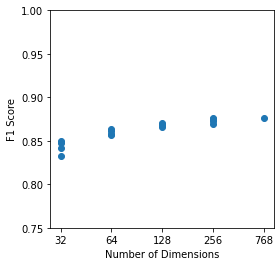

In [42]:
# Plot the tradeoff between dimensionality and F1 score
x = summary_df["n_components"].astype(str)  # Treat num dims as categorical
y = summary_df["F1"]

plt.figure(figsize=(4,4))
plt.scatter(x, y)
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("Number of Dimensions")
plt.ylabel("F1 Score")
plt.ylim([0.75, 1.0])

# Also dump the raw data to a local file.
pd.DataFrame({"num_dims": x, "f1_score": y}).to_csv("outputs/dims_vs_f1_score.csv",
                                                    index=False)

plt.show()

In [43]:
# Tabulate all the results as in CoNLL_2.ipynb
test_results_full = util.merge_model_results(test_results)
test_results_full

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=231, style=ProgressStyle(desc…

,doc_num,fold,doc_offset,span,ent_type,gold,32_1,32_2,32_3,32_4,...,128_1,128_2,128_3,128_4,256_1,256_2,256_3,256_4,768_1,num_models
0,0,test,0,"[19, 24): 'JAPAN'",LOC,True,False,False,False,True,...,False,False,False,True,False,False,False,True,False,3
1,0,test,0,"[40, 45): 'CHINA'",PER,True,False,False,False,False,...,False,False,False,True,False,False,True,False,False,3
2,0,test,0,"[66, 77): 'Nadim Ladki'",PER,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,0,test,0,"[78, 84): 'AL-AIN'",LOC,True,False,False,False,False,...,False,False,False,False,False,False,True,False,True,2
4,0,test,0,"[86, 106): 'United Arab Emirates'",LOC,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,230,test,230,"[1071, 1075): '1988'",MISC,False,False,True,False,False,...,False,True,False,False,False,True,False,False,False,4
33,230,test,230,"[19, 29): 'ENGLISHMAN'",LOC,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,1
34,230,test,230,"[19, 29): 'ENGLISHMAN'",PER,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
35,230,test,230,"[1076, 1097): 'European championship'",MISC,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


In [44]:
# Drop the Boolean columns for convenience
test_results = test_results_full[["fold", "doc_offset", "span", 
                                  "ent_type", "gold", "num_models"]]
test_results

,fold,doc_offset,span,ent_type,gold,num_models
0,test,0,"[19, 24): 'JAPAN'",LOC,True,3
1,test,0,"[40, 45): 'CHINA'",PER,True,3
2,test,0,"[66, 77): 'Nadim Ladki'",PER,True,0
3,test,0,"[78, 84): 'AL-AIN'",LOC,True,2
4,test,0,"[86, 106): 'United Arab Emirates'",LOC,True,17
...,...,...,...,...,...,...
32,test,230,"[1071, 1075): '1988'",MISC,False,4
33,test,230,"[19, 29): 'ENGLISHMAN'",LOC,False,1
34,test,230,"[19, 29): 'ENGLISHMAN'",PER,False,1
35,test,230,"[1076, 1097): 'European championship'",MISC,False,1


In [45]:
# How many results are in the gold standard?
test_results[test_results["gold"]]

,fold,doc_offset,span,ent_type,gold,num_models
0,test,0,"[19, 24): 'JAPAN'",LOC,True,3
1,test,0,"[40, 45): 'CHINA'",PER,True,3
2,test,0,"[66, 77): 'Nadim Ladki'",PER,True,0
3,test,0,"[78, 84): 'AL-AIN'",LOC,True,2
4,test,0,"[86, 106): 'United Arab Emirates'",LOC,True,17
...,...,...,...,...,...,...
23,test,230,"[1153, 1160): 'England'",LOC,True,17
24,test,230,"[1213, 1225): 'Leeds United'",ORG,True,17
25,test,230,"[1252, 1259): 'England'",LOC,True,17
26,test,230,"[1341, 1355): '1966 World Cup'",MISC,True,0


In [46]:
# How many entities were found by zero models?
(test_results[test_results["gold"] == True]
 [["num_models", "span"]]
 .groupby("num_models").count()
 .rename(columns={"span": "count"}))

,count
num_models,
0,406
1,81
2,49
3,47
4,39
5,44
6,36
7,45
8,49


In [47]:
# How many non-results were found by many models?
(test_results[test_results["gold"] == False]
 [["num_models", "span"]]
 .groupby("num_models").count()
 .rename(columns={"span": "count"}))

,count
num_models,
1,1133
2,388
3,207
4,158
5,103
6,77
7,60
8,57
9,50


In [48]:
# Hardest results from the gold standard to get.
# Use document ID to break ties.
test_hard_to_get = (
    test_results[test_results["gold"]]
    .sort_values(["num_models", "fold", "doc_offset"])
    .head(20))
test_hard_to_get

,fold,doc_offset,span,ent_type,gold,num_models
2,test,0,"[66, 77): 'Nadim Ladki'",PER,True,0
2,test,1,"[42, 47): 'ITALY'",LOC,True,0
17,test,1,"[686, 700): '1995 World Cup'",MISC,True,0
0,test,2,"[35, 40): 'JAPAN'",LOC,True,0
0,test,3,"[21, 37): 'SKIING-WORLD CUP'",MISC,True,0
51,test,5,"[1042, 1050): 'N. Astle'",PER,True,0
2,test,6,"[88, 110): 'English F.A. Challenge'",MISC,True,0
3,test,6,"[111, 114): 'Cup'",MISC,True,0
14,test,7,"[490, 497): 'Udinese'",ORG,True,0
16,test,7,"[645, 654): 'Feyenoord'",ORG,True,0


### Results from hand-labeling the above 20 examles:

#### TODO: Update this cell with table from CSV file

In [49]:
# Hardest results not in the gold standard to avoid
test_hard_to_avoid = (
    test_results[~test_results["gold"]]
    .sort_values(["num_models", "fold", "doc_offset"], 
                 ascending=[False, True, True])
    .head(20))
test_hard_to_avoid

,fold,doc_offset,span,ent_type,gold,num_models
47,test,1,"[691, 700): 'World Cup'",MISC,False,17
38,test,11,"[495, 509): 'Desvonde Botes'",PER,False,17
47,test,23,"[94, 116): 'National Hockey League'",MISC,False,17
19,test,24,"[211, 233): 'National Hockey League'",MISC,False,17
59,test,26,"[1099, 1119): 'SACRAMENTO VANCOUVER'",LOC,False,17
29,test,31,"[532, 542): 'FC Cologne'",ORG,False,17
30,test,31,"[561, 568): 'Schalke'",ORG,False,17
17,test,32,"[170, 188): 'Jocelyn Gourvennec'",PER,False,17
21,test,36,"[349, 358): 'Karlsruhe'",ORG,False,17
23,test,36,"[398, 406): 'Freiburg'",ORG,False,17


### Results from hand-labeling the above 20 examles:

#### TODO: Update this cell with table from CSV file

## Use the same models to find incorrect labels in the development set

In [50]:
dev_df = corpus_df[corpus_df["fold"] == "dev"]
dev_results_by_model = {
    name: util.analyze_model(dev_df, int_to_label, model, bert_toks_by_fold, 
                             corpus_raw, expand_matches=True) 
    for name, model in models.items()
}

In [51]:
dev_results_full = util.merge_model_results(dev_results_by_model)
dev_results_full

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=216, style=ProgressStyle(desc…

,doc_num,fold,doc_offset,span,ent_type,gold,32_1,32_2,32_3,32_4,...,128_1,128_2,128_3,128_4,256_1,256_2,256_3,256_4,768_1,num_models
0,0,dev,0,"[20, 34): 'LEICESTERSHIRE'",ORG,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,0,dev,0,"[75, 81): 'LONDON'",LOC,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17
2,0,dev,0,"[93, 104): 'West Indian'",MISC,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,16
3,0,dev,0,"[117, 129): 'Phil Simmons'",PER,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17
4,0,dev,0,"[160, 174): 'Leicestershire'",ORG,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,215,dev,215,"[977, 991): 'Dhaka Newsroom'",ORG,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17
13,215,dev,215,"[291, 304): 'Moslem Friday'",MISC,False,True,True,True,True,...,True,True,False,True,False,True,False,True,False,12
14,215,dev,215,"[433, 439): 'Shakil'",PER,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1
15,215,dev,215,"[454, 462): 'Khurshid'",PER,False,True,True,False,True,...,False,False,False,False,False,False,False,False,False,4


In [52]:
dev_results = dev_results_full[["fold", "doc_offset", "span", "ent_type", "gold", "num_models"]]
dev_results

,fold,doc_offset,span,ent_type,gold,num_models
0,dev,0,"[20, 34): 'LEICESTERSHIRE'",ORG,True,0
1,dev,0,"[75, 81): 'LONDON'",LOC,True,17
2,dev,0,"[93, 104): 'West Indian'",MISC,True,16
3,dev,0,"[117, 129): 'Phil Simmons'",PER,True,17
4,dev,0,"[160, 174): 'Leicestershire'",ORG,True,17
...,...,...,...,...,...,...
12,dev,215,"[977, 991): 'Dhaka Newsroom'",ORG,True,17
13,dev,215,"[291, 304): 'Moslem Friday'",MISC,False,12
14,dev,215,"[433, 439): 'Shakil'",PER,False,1
15,dev,215,"[454, 462): 'Khurshid'",PER,False,4


In [53]:
(dev_results[dev_results["gold"] == True][["num_models", "span"]]
 .groupby("num_models").count()
 .rename(columns={"span": "count"}))

,count
num_models,
0,199
1,61
2,37
3,45
4,30
5,44
6,36
7,40
8,40


In [54]:
(dev_results[dev_results["gold"] == False][["num_models", "span"]]
 .groupby("num_models").count()
 .rename(columns={"span": "count"}))

,count
num_models,
1,832
2,281
3,186
4,101
5,72
6,66
7,47
8,38
9,29


In [55]:
dev_hard_to_get = dev_results[dev_results["gold"]].sort_values(["num_models", "fold", "doc_offset"]).head(20)
dev_hard_to_get

,fold,doc_offset,span,ent_type,gold,num_models
0,dev,0,"[20, 34): 'LEICESTERSHIRE'",ORG,True,0
46,dev,0,"[2225, 2235): 'ex-England'",MISC,True,0
0,dev,2,"[25, 30): 'ASHES'",MISC,True,0
3,dev,2,"[87, 92): 'Ashes'",MISC,True,0
13,dev,2,"[614, 634): 'Duke of Norfolk's XI'",ORG,True,0
0,dev,6,"[19, 24): 'ROTOR'",ORG,True,0
5,dev,6,"[262, 267): 'Rotor'",ORG,True,0
8,dev,6,"[399, 404): 'Rotor'",ORG,True,0
14,dev,7,"[993, 1003): 'Panamanian'",MISC,True,0
15,dev,7,"[1004, 1022): 'Boxing Association'",ORG,True,0


### Results from hand-labeling:

Document | Error Type | Corpus Span                | Tag      | Corrected Span | Tag       | Notes
---------|------------|----------------------------|----------|----------------|-----------|----------------------------------------------------------------
0        | None       | `[66, 77): 'Nadim Ladki'`  | `PER`    |                |           | 
0        | None       | `[78, 84): 'AL-AIN'`       | `LOC`    |
0        | None       | `[1824, 1831): 'Syrians'`  | `MISC`   |
1        | Tag        | `[42, 47): 'ITALY'`        | `LOC`    |                | `ORG`     | Italian World Cup team
1        | None       | `[686, 700): '1995 World Cup'` | `MISC`
3        | Span       | `[21, 37): 'SKIING-WORLD CUP'` | `MISC`| `[28, 37): 'WORLD CUP'` | | "FREESTYLE SKIING-WORLD CUP MOGUL RESULTS."
5        | Tag        | `[31, 42): 'NEW ZEALAND'`  | `LOC`    |                | `ORG`
5        | None       | `[223, 234): 'Saeed Anwar'`| `PER`
5        | None       | `[280, 286): 'Cairns'`     | `PER`
5        | None       | `[779, 785): 'Cairns'`     | `PER`
6        | Sentence   | `[88, 110): 'English F.A. Challenge'` | `MISC` | `[88, 114): 'English F.A. Challenge Cup'`
6        | Sentence   | `[111, 114): 'Cup'`        | `MISC`   | `[88, 114): 'English F.A. Challenge Cup'`
7        | None       | `[491, 498): 'Udinese'`    | `ORG`
7        | None       | `[646, 655): 'Feyenoord'`  | `ORG`
7        | Spelling   | `[772, 779): 'Engllsh'`    | `MISC`   | `[772, 779): 'English'`
8        | None       | `[26, 32): 'BOWYER'`       | `PER`
8        | None       | `[94, 101): 'England'`     | `LOC`
9        | None       | `[23, 33): 'EUROLEAGUE'`   | `MISC`



In [56]:
# Hardest results from the gold standard to avoid
dev_hard_to_avoid = dev_results[~dev_results["gold"]].sort_values(
    ["num_models", "fold", "doc_offset"], ascending=False).head(20)
dev_hard_to_avoid

,fold,doc_offset,span,ent_type,gold,num_models
51,dev,214,"[187, 202): 'Michael Collins'",PER,False,17
73,dev,206,"[2472, 2483): 'Carl Vinson'",PER,False,17
7,dev,199,"[106, 122): 'Turkish-operated'",MISC,False,17
34,dev,197,"[500, 507): 'Lebanon'",LOC,False,17
25,dev,185,"[54, 62): 'SANTIAGO'",LOC,False,17
28,dev,184,"[789, 795): 'Granma'",PER,False,17
23,dev,178,"[11, 32): 'S. African Afrikaners'",MISC,False,17
27,dev,178,"[1513, 1522): 'Coloureds'",MISC,False,17
111,dev,170,"[1965, 1980): 'Cardinal Wolsey'",PER,False,17
114,dev,170,"[2972, 2991): 'Alan John Percivale'",PER,False,17


### Results from hand-labeling the above 20 examples

Document | Error Type | Model Span                     | Tag      | Corpus Span                | Corpus Tag | Notes
---------|------------|--------------------------------|----------|----------------------------|------------|-----------------------------------------------------
229      | Span       | `[704, 718): 'Sporting Gijon'` | `LOC`    |`[704, 712): 'Sporting'`    | `ORG`      |
223      | Tag        | `[232, 244): 'Philadelphia'`   | `ORG`    |                            | `LOC`      | Hockey team
223      | Tag        | `[247, 253): 'DALLAS'`         | `ORG`    |                            | `LOC`      | Hockey team
223      | Tag        | `[256, 264): 'St Louis'`       | `ORG`    |                            | `LOC`      | Hockey team
223      | Tag        | `[267, 275): 'COLORADO'`       | `ORG`    |                            | `LOC`      | Hockey team
223      | Tag        | `[289, 295): 'Ottawa'`         | `ORG`    |                            | `LOC`      | Hockey team
222      | Sentence   | `[93, 115): 'National Hockey League'` | `MISC` | `[93, 108): 'National Hockey'`
222      | Sentence   | `[93, 115): 'National Hockey League'` | `MISC` | `[109, 115): 'League'`
219      | Tag        | `[562, 565): 'UAE'`            | `ORG`    |                            | `LOC`      | Soccer team
213      | Sentence   | `[697, 708): 'Dion Fourie'`    | `PER`    | `[697, 701): 'Dion'`
213      | Sentence   | `[697, 708): 'Dion Fourie'`    | `PER`    | `[702, 708): 'Fourie'`
210      | None       | `[942, 944): 'Bo'`             | `ORG`    | `[942, 954): 'Boreham Wood'` |          | Split token
210      | None       | `[944, 954): 'reham Wood'`     | `ORG`    | `[942, 954): 'Boreham Wood'` |          | Split token
209      | Sentence   | `[384, 393): 'East Fife'`      | `ORG`    | `[384, 388): 'East'`
209      | Sentence   | `[384, 393): 'East Fife'`      | `ORG`    | `[389, 393): 'Fife'`
207      | None       | `[2726, 2728): 'Le'`           | `ORG`    | `[2726, 2739): 'Leyton Orient'` |       | Split token
207      | None       | `[2728, 2739): 'yton Orient'`  | `ORG`    | `[2726, 2739): 'Leyton Orient'` |       | Split token
205      | Tag        | `[627, 636): 'Wimbledon'`      | `ORG`    |                            | `LOC`      | Soccer team
202      | None       | `[150, 151): 'W'`              | `ORG`    | `[150, 156): 'Widnes'`     |            | Split token
202      | None       | `[151, 156): 'idnes'`          | `ORG`    | `[150, 156): 'Widnes'`     |            | Split token
200      | Sentence   | `[284, 295): 'Aston Villa'`    | `ORG`    | `[284, 289): 'Aston'`
200      | Sentence   | `[284, 295): 'Aston Villa'`    | `ORG`    | `[290, 295): 'Villa'`
200      | Tag        | `[337, 346): 'Wimbledon'`      | `ORG`    |                            | `LOC`      | Soccer team


## Also look for incorrect labels on the training set

Apply the same process to the training set to see what we get. Since these
models are trained on this set, we don't expect their aggregate results to
flag many incorrect labels. Generate the data anyhow just to see what happens.

In [57]:
train_df = corpus_df[corpus_df["fold"] == "train"]
train_results_by_model = {
    name: util.analyze_model(train_df, int_to_label, model, bert_toks_by_fold, 
                             corpus_raw, expand_matches=True) 
    for name, model in models.items()
}

In [58]:
train_results_full = util.merge_model_results(train_results_by_model)
train_results_full

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=946, style=ProgressStyle(desc…

,doc_num,fold,doc_offset,span,ent_type,gold,32_1,32_2,32_3,32_4,...,128_1,128_2,128_3,128_4,256_1,256_2,256_3,256_4,768_1,num_models
0,0,train,0,"[11, 13): 'EU'",ORG,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17
1,0,train,0,"[22, 28): 'German'",MISC,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17
2,0,train,0,"[45, 52): 'British'",MISC,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17
3,0,train,0,"[59, 74): 'Peter Blackburn'",PER,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,2
4,0,train,0,"[75, 83): 'BRUSSELS'",LOC,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,945,train,945,"[72, 79): 'English'",MISC,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17
3,945,train,945,"[119, 127): 'Plymouth'",ORG,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17
4,945,train,945,"[130, 137): 'Preston'",ORG,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17
5,945,train,945,"[155, 162): 'Swansea'",ORG,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17


In [59]:
train_results = train_results_full[["fold", "doc_offset", "span", "ent_type", "gold", "num_models"]]
train_results

,fold,doc_offset,span,ent_type,gold,num_models
0,train,0,"[11, 13): 'EU'",ORG,True,17
1,train,0,"[22, 28): 'German'",MISC,True,17
2,train,0,"[45, 52): 'British'",MISC,True,17
3,train,0,"[59, 74): 'Peter Blackburn'",PER,True,2
4,train,0,"[75, 83): 'BRUSSELS'",LOC,True,1
...,...,...,...,...,...,...
2,train,945,"[72, 79): 'English'",MISC,True,17
3,train,945,"[119, 127): 'Plymouth'",ORG,True,17
4,train,945,"[130, 137): 'Preston'",ORG,True,17
5,train,945,"[155, 162): 'Swansea'",ORG,True,17


In [60]:
(train_results[train_results["gold"] == True][["num_models", "span"]]
 .groupby("num_models").count()
 .rename(columns={"span": "count"}))

,count
num_models,
0,250
1,148
2,107
3,117
4,72
5,111
6,103
7,131
8,117


In [61]:
(train_results[train_results["gold"] == False][["num_models", "span"]]
 .groupby("num_models").count()
 .rename(columns={"span": "count"}))

,count
num_models,
1,2171
2,726
3,403
4,268
5,169
6,122
7,95
8,65
9,79


In [62]:
train_hard_to_get = train_results[train_results["gold"]].sort_values(["num_models", "fold", "doc_offset"]).head(20)
train_hard_to_get

,fold,doc_offset,span,ent_type,gold,num_models
3,train,6,"[121, 137): 'Toronto Dominion'",PER,True,0
4,train,24,"[161, 169): 'Africans'",MISC,True,0
4,train,25,"[141, 151): 'mid-Norway'",MISC,True,0
22,train,29,"[454, 458): 'Phil'",PER,True,0
23,train,29,"[459, 468): 'Mickelson'",PER,True,0
46,train,29,"[762, 766): 'Mark'",PER,True,0
47,train,29,"[767, 774): 'O'Meara'",PER,True,0
38,train,37,"[837, 841): 'Moin'",PER,True,0
39,train,37,"[842, 846): 'Khan'",PER,True,0
1,train,40,"[55, 72): 'MANCHESTER UNITED'",LOC,True,0


In [63]:
# Hardest results from the gold standard to avoid
train_hard_to_avoid = train_results[~train_results["gold"]].sort_values(
    ["num_models", "fold", "doc_offset"], ascending=False).head(20)
train_hard_to_avoid

,fold,doc_offset,span,ent_type,gold,num_models
57,train,944,"[1030, 1042): 'South Africa'",LOC,False,17
58,train,937,"[1626, 1652): 'Goldman, Sachs and Co. Inc'",ORG,False,17
18,train,930,"[698, 707): 'CDU No. 3'",ORG,False,17
33,train,819,"[84, 105): 'Major League Baseball'",MISC,False,17
51,train,803,"[786, 806): 'Lampros Vasilopoulos'",PER,False,17
55,train,801,"[50, 54): 'TOUR'",MISC,False,17
65,train,800,"[478, 488): 'Mark Davis'",PER,False,17
66,train,800,"[552, 565): 'Retief Goosen'",PER,False,17
67,train,800,"[831, 842): 'Ian Woosnam'",PER,False,17
68,train,800,"[886, 899): 'Klas Eriksson'",PER,False,17


# Write CSV files for manual labeling

Generate CSV outputs like the ones from `CoNLL_2.ipynb` so that we can 
manually label the examples our ensemble flagged in the development test sets.

In [64]:
# First pair of files contains the outputs for the dev and test
# sets, as in the output of CoNLL_2.ipynb
dev_and_test_results = pd.concat([dev_results, test_results])
in_gold_to_write, not_in_gold_to_write = util.csv_prep(dev_and_test_results, "num_models")
in_gold_to_write

,num_models,fold,doc_offset,corpus_span,corpus_ent_type,error_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
0,0,dev,0,"[20, 34): 'LEICESTERSHIRE'",ORG,,,,,,,
46,0,dev,0,"[2225, 2235): 'ex-England'",MISC,,,,,,,
0,0,dev,2,"[25, 30): 'ASHES'",MISC,,,,,,,
3,0,dev,2,"[87, 92): 'Ashes'",MISC,,,,,,,
13,0,dev,2,"[614, 634): 'Duke of Norfolk's XI'",ORG,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
21,17,test,230,"[1108, 1115): 'Germany'",LOC,,,,,,,
23,17,test,230,"[1153, 1160): 'England'",LOC,,,,,,,
24,17,test,230,"[1213, 1225): 'Leeds United'",ORG,,,,,,,
25,17,test,230,"[1252, 1259): 'England'",LOC,,,,,,,


In [65]:
not_in_gold_to_write

,num_models,fold,doc_offset,model_span,model_ent_type,error_type,corpus_span,corpus_ent_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
51,17,dev,0,"[2225, 2235): 'ex-England'",LOC,,,,,,,,,
18,17,dev,6,"[262, 267): 'Rotor'",PER,,,,,,,,,
19,17,dev,6,"[399, 404): 'Rotor'",PER,,,,,,,,,
101,17,dev,11,"[1961, 1975): 'Czech Republic'",LOC,,,,,,,,,
25,17,dev,13,"[83, 104): 'Major League Baseball'",MISC,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,1,test,230,"[19, 29): 'ENGLISHMAN'",ORG,,,,,,,,,
33,1,test,230,"[19, 29): 'ENGLISHMAN'",LOC,,,,,,,,,
34,1,test,230,"[19, 29): 'ENGLISHMAN'",PER,,,,,,,,,
35,1,test,230,"[1076, 1097): 'European championship'",MISC,,,,,,,,,


In [66]:
# Write the CSV file for test and validation results
in_gold_to_write.to_csv("outputs/CoNLL_3_in_gold.csv", index=False)
not_in_gold_to_write.to_csv("outputs/CoNLL_3_not_in_gold.csv", index=False)

In [67]:
# Generate a second pair of dataframes with results on the training set
train_in_gold, train_not_in_gold = util.csv_prep(train_results, "num_models")
train_in_gold

,num_models,fold,doc_offset,corpus_span,corpus_ent_type,error_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
3,0,train,6,"[121, 137): 'Toronto Dominion'",PER,,,,,,,
4,0,train,24,"[161, 169): 'Africans'",MISC,,,,,,,
4,0,train,25,"[141, 151): 'mid-Norway'",MISC,,,,,,,
22,0,train,29,"[454, 458): 'Phil'",PER,,,,,,,
23,0,train,29,"[459, 468): 'Mickelson'",PER,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
2,17,train,945,"[72, 79): 'English'",MISC,,,,,,,
3,17,train,945,"[119, 127): 'Plymouth'",ORG,,,,,,,
4,17,train,945,"[130, 137): 'Preston'",ORG,,,,,,,
5,17,train,945,"[155, 162): 'Swansea'",ORG,,,,,,,


In [68]:
train_not_in_gold

,num_models,fold,doc_offset,model_span,model_ent_type,error_type,corpus_span,corpus_ent_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
13,17,train,6,"[121, 137): 'Toronto Dominion'",LOC,,,,,,,,,
66,17,train,29,"[454, 468): 'Phil Mickelson'",PER,,,,,,,,,
67,17,train,29,"[762, 774): 'Mark O'Meara'",PER,,,,,,,,,
48,17,train,37,"[837, 846): 'Moin Khan'",PER,,,,,,,,,
64,17,train,41,"[364, 378): 'Czech Republic'",LOC,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1,train,944,"[11, 15): 'GOLF'",LOC,,,,,,,,,
59,1,train,944,"[33, 38): 'THIRD'",MISC,,,,,,,,,
60,1,train,944,"[45, 51): 'SCORES'",MISC,,,,,,,,,
64,1,train,944,"[129, 136): 'British'",MISC,,,,,,,,,


In [69]:
# Write the training set information to a second pair of CSV files
train_in_gold.to_csv("outputs/CoNLL_3_train_in_gold.csv", index=False)
train_not_in_gold.to_csv("outputs/CoNLL_3_train_not_in_gold.csv", index=False)